In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Optional but nice (only if installed)
try:
    import seaborn as sns
    sns.set(style="whitegrid")
    HAS_SNS = True
except ImportError:
    HAS_SNS = False

DATA_DIR = "../data"  # notebook is in notebooks/, data is ../data

In [2]:
paths = sorted(glob.glob(f"{DATA_DIR}/auth_windows_*.csv"))
print(f"Found {len(paths)} auth_windows files")

df = pd.concat([pd.read_csv(p) for p in paths], ignore_index=True)

print("Shape:", df.shape)
df.head()

Found 1 auth_windows files
Shape: (7, 32)


,sessionId,participantId,sessionIndex,timeBucket,fatigue,inputDevice,typing_ikt_global_mean,typing_ikt_global_std,typing_ikt_global_iqr,typing_ikt_global_p95,...,tap_rt_p95,tap_miss_rate_pct,tap_drift_rt,tap_error_recovery_miss_median,coupling_var_ikt,coupling_var_rt,coupling_var_ratio,windowIndex,windowStartMs,windowEndMs
0,1ea8d3a866aa482f951c9734e8232bd4,p1,12,morning,4,touch,298.0,352.0,125.0,1157.0,...,NaN,0,NaN,NaN,123654.566205,NaN,NaN,0,537629,567629
1,1ea8d3a866aa482f951c9734e8232bd4,p1,12,morning,4,touch,277.0,345.0,125.0,1183.0,...,NaN,0,NaN,NaN,119231.298447,NaN,NaN,1,552629,582629
2,1ea8d3a866aa482f951c9734e8232bd4,p1,12,morning,4,touch,307.0,384.0,113.0,1220.0,...,NaN,0,NaN,NaN,147385.915125,NaN,NaN,2,567629,597629
3,1ea8d3a866aa482f951c9734e8232bd4,p1,12,morning,4,touch,361.0,424.0,295.0,1248.0,...,1366.0,5,NaN,NaN,179614.481994,92924.793651,0.517,3,582629,612629
4,1ea8d3a866aa482f951c9734e8232bd4,p1,12,morning,4,touch,NaN,NaN,NaN,NaN,...,987.0,4,-73.0,NaN,NaN,54083.740247,NaN,4,597629,627629


In [3]:
required = ["participantId","sessionId","windowIndex","windowStartMs","windowEndMs"]
missing_cols = [c for c in required if c not in df.columns]
assert not missing_cols, f"Missing required columns: {missing_cols}"

# one row per window identifier
dupes = df.duplicated(subset=["participantId","sessionId","windowIndex"]).sum()
print("Duplicate (participantId,sessionId,windowIndex) rows:", dupes)

# window counts per session
counts = df.groupby(["participantId","sessionId"])["windowIndex"].count().sort_values()
print("Window count per session — summary:")
display(counts.describe())

print("Example sessions (lowest counts):")
display(counts.head(10))

Duplicate (participantId,sessionId,windowIndex) rows: 0
Window count per session — summary:


count    1.0
mean     7.0
std      NaN
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
Name: windowIndex, dtype: float64

Example sessions (lowest counts):


participantId  sessionId                       
p1             1ea8d3a866aa482f951c9734e8232bd4    7
Name: windowIndex, dtype: int64

In [4]:
def is_monotonic(g):
    return g["windowIndex"].is_monotonic_increasing and g["windowStartMs"].is_monotonic_increasing

mono = df.groupby(["participantId","sessionId"]).apply(is_monotonic)
print(mono.value_counts())

True    1
Name: count, dtype: int64


In [5]:
missing_frac = df.isna().mean().sort_values(ascending=False)
missing_pct = (100 * missing_frac).round(1)

missing_table = pd.DataFrame({
    "missing_%": missing_pct,
    "non_missing_n": df.notna().sum()
})

display(missing_table.head(30))

,missing_%,non_missing_n
coupling_var_ikt,42.9,4
coupling_var_ratio,85.7,1
coupling_var_rt,42.9,4
fatigue,0.0,7
inputDevice,0.0,7
participantId,0.0,7
sessionId,0.0,7
sessionIndex,0.0,7
tap_drift_rt,57.1,3
tap_error_recovery_miss_median,100.0,0


In [6]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

by_w = df.groupby("windowIndex")[numeric_cols].apply(lambda x: x.isna().mean()).T * 100
by_w = by_w.round(1)

# show a few key features if present
key_feats = [c for c in [
    "typing_drift_ikt",
    "tap_drift_rt",
    "typing_error_recovery_wrong_median",
    "tap_error_recovery_miss_median",
    "typing_accuracy_pct",
    "tap_miss_rate_pct"
] if c in df.columns]

display(by_w.loc[key_feats] if key_feats else by_w.head(10))

windowIndex,0,1,2,3,4,5,6
typing_drift_ikt,0.0,0.0,0.0,100.0,100.0,100.0,100.0
tap_drift_rt,100.0,100.0,100.0,100.0,0.0,0.0,0.0
typing_error_recovery_wrong_median,100.0,100.0,100.0,100.0,100.0,100.0,100.0
tap_error_recovery_miss_median,100.0,100.0,100.0,100.0,100.0,100.0,100.0
typing_accuracy_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tap_miss_rate_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Core cols found: ['typing_ikt_global_mean', 'typing_ikt_global_p95', 'typing_accuracy_pct', 'tap_rt_mean', 'tap_rt_p95', 'tap_miss_rate_pct', 'coupling_var_ratio']


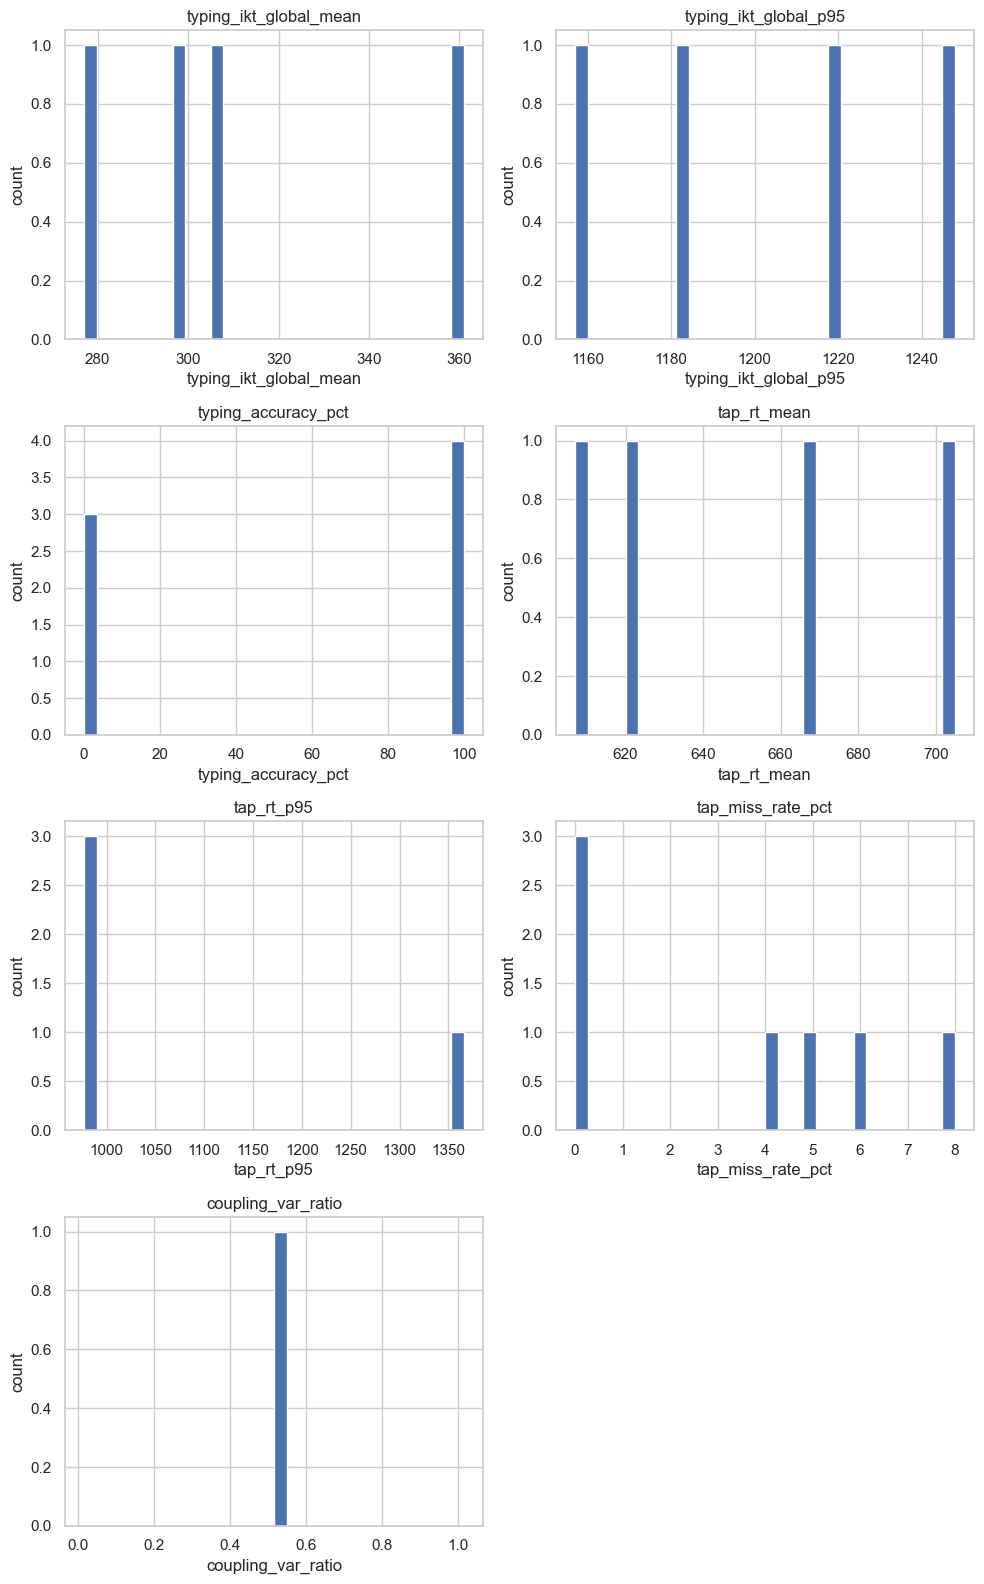

In [7]:
core = [c for c in [
    "typing_ikt_global_mean",
    "typing_ikt_global_p95",
    "typing_accuracy_pct",
    "tap_rt_mean",
    "tap_rt_p95",
    "tap_miss_rate_pct",
    "coupling_var_ratio"
] if c in df.columns]

print("Core cols found:", core)

n = len(core)
fig, axes = plt.subplots((n+1)//2, 2, figsize=(10, 4*((n+1)//2)))
axes = np.array(axes).reshape(-1)

for ax, col in zip(axes, core):
    x = df[col].dropna()
    ax.hist(x, bins=30)
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("count")

# tidy extra axes
for ax in axes[len(core):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [8]:
checks = []

def add_check(col, lo, hi):
    if col in df.columns:
        x = df[col].dropna()
        bad = ((x < lo) | (x > hi)).sum()
        checks.append((col, lo, hi, int(bad), float(x.min()), float(x.max())))

# Broad “human plausible” bounds (not strict)
add_check("typing_ikt_global_mean", 50, 1500)
add_check("typing_ikt_global_p95", 100, 4000)
add_check("tap_rt_mean", 100, 3000)
add_check("tap_rt_p95", 150, 5000)
add_check("typing_accuracy_pct", 0, 100)
add_check("tap_miss_rate_pct", 0, 100)
add_check("coupling_var_ratio", 0, 10)

check_df = pd.DataFrame(checks, columns=["feature","lo","hi","n_outside","min","max"])
display(check_df)

,feature,lo,hi,n_outside,min,max
0,typing_ikt_global_mean,50,1500,0,277.000,361.000
1,typing_ikt_global_p95,100,4000,0,1157.000,1248.000
2,tap_rt_mean,100,3000,0,607.000,705.000
3,tap_rt_p95,150,5000,0,977.000,1366.000
4,typing_accuracy_pct,0,100,0,0.000,100.000
5,tap_miss_rate_pct,0,100,0,0.000,8.000
6,coupling_var_ratio,0,10,0,0.517,0.517


In [9]:
if df["participantId"].nunique() >= 2:
    # Between-user vs within-user variance per feature (rough proxy)
    feats = [c for c in numeric_cols if c not in ["windowStartMs","windowEndMs","windowIndex"]]
    feats = [c for c in feats if df[c].notna().sum() > 0]

    user_means = df.groupby("participantId")[feats].mean(numeric_only=True)
    between = user_means.var()

    within = df.groupby("participantId")[feats].var().mean()

    signal = (between / (within + 1e-9)).sort_values(ascending=False)
    display(signal.head(20).to_frame("between/within"))
else:
    print("Need >=2 participants to compute between/within-user variance proxy.")

Need >=2 participants to compute between/within-user variance proxy.
